In [1]:
import time
import msgpack
from enum import Enum, auto

import numpy as np

from planning_utils import a_star, heuristic, create_grid, get_home_position
from motion_planning import MotionPlanning
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local


In [2]:
filename = 'colliders.csv'

In [3]:
# First Line of the file is the home location
# Second line is the header
def get_home_position(fileneame):
    with open(filename) as f:
        first_line = list(f)[0:1]
    f.close()
    lat,lon = first_line[0].split(',')
    _,lat0 = lat.split()
    _,lon0 = lon.split()
    
    print(first_line)
    return lat0,lon0

In [4]:
lat0,lon0 = get_home_position(filename)

['lat0 37.792480, lon0 -122.397450\n']


In [5]:
print(lat0)
print(lon0)

37.792480
-122.397450


In [6]:
# This is the obstacle data loaded from the file (2.5d Map).
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [8]:
# Static drone altitude (meters)
drone_altitude = 0
# Minimum distance stay away from obstacle (meters)
safe_distance = 0
grid, north_offset, east_offset = create_grid(data, drone_altitude, safe_distance)

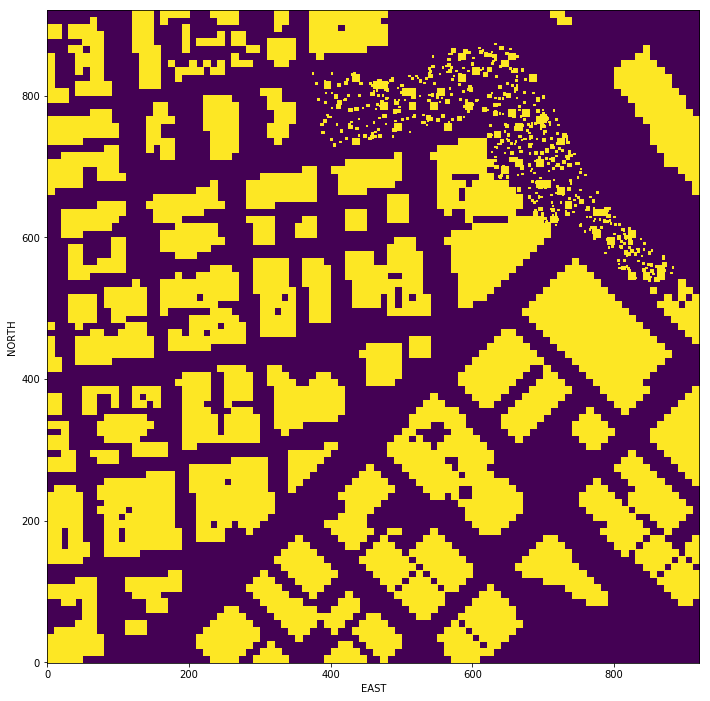

In [9]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.rcParams['figure.figsize'] = 12, 12
plt.imshow(grid, origin='lower') 
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [10]:
# Static drone altitude (meters)
drone_altitude = 5
# Minimum distance stay away from obstacle (meters)
safe_distance = 5
grid, north_offset, east_offset = create_grid(data, drone_altitude, safe_distance)

In [11]:
global_home  = np.array([lon0, lat0, 0], dtype='Float64')
global_position = np.array([lon0, lat0, 0], dtype='Float64')

from udacidrone.frame_utils import global_to_local
local_north, local_east, _ = global_to_local(global_position, global_home )
grid_start_north = int(np.ceil(local_north - north_offset))
grid_start_east = int(np.ceil(local_east - east_offset))

print("Global Lon: {0} Lat: {1}".format(global_home[0],global_home[1]))
print("Local North: {0} East: {1}".format(grid_start_north,grid_start_east))

Global Lon: -122.39745 Lat: 37.79248
Local North: 316 East: 445


/home/santhosh/anaconda3/envs/fcnd/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  """Entry point for launching an IPython kernel.
/home/santhosh/anaconda3/envs/fcnd/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


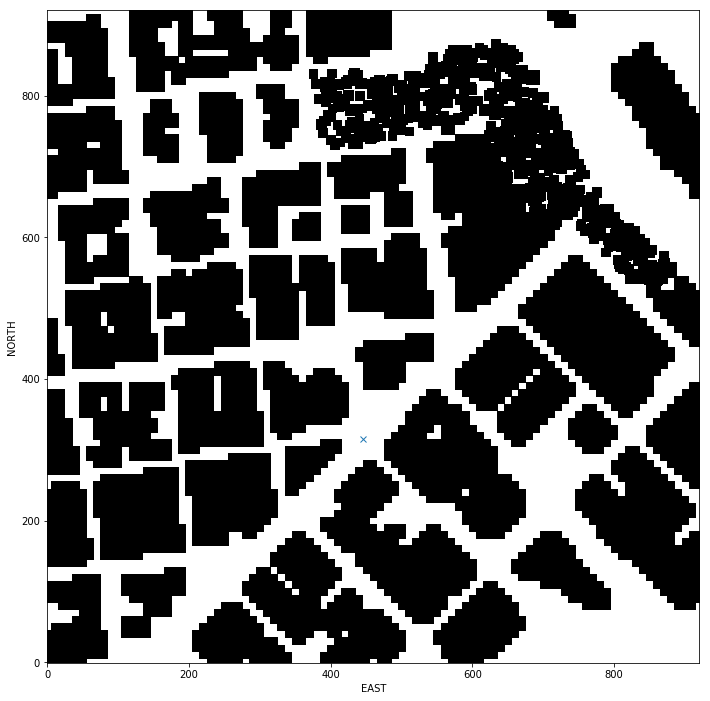

In [12]:
plt.rcParams['figure.figsize'] = 12, 12
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(grid_start_east, grid_start_north, 'x')
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [13]:
from udacidrone.frame_utils import local_to_global

In [14]:
goal_north = 745 
goal_east = 372
grid_goal_north = int(np.ceil(goal_north + north_offset))
grid_goal_east = int(np.ceil(goal_east + east_offset))
local_to_global([grid_goal_north,grid_goal_east,0],global_home)

array([-122.3982477 ,   37.79635069,    0.        ])

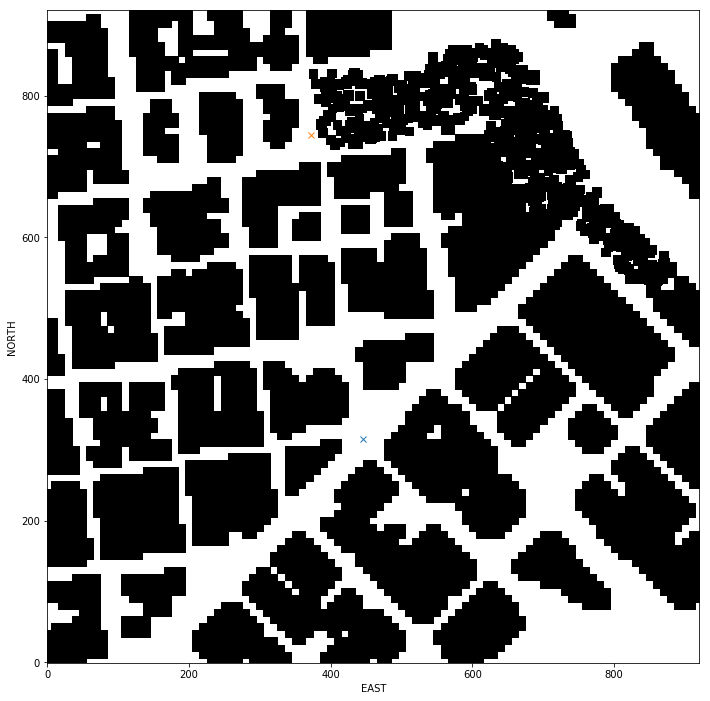

In [15]:
grid, north_offset, east_offset = create_grid(data, drone_altitude, safe_distance)
plt.rcParams['figure.figsize'] = 12, 12
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(grid_start_east, grid_start_north, 'x')
plt.plot(goal_east, goal_north, 'x')
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [16]:
goal_north = 810 
goal_east = 110
grid_goal_north = int(np.ceil(goal_north + north_offset))
grid_goal_east = int(np.ceil(goal_east + east_offset))
local_to_global([grid_goal_north,grid_goal_east,0],global_home)

array([-122.40121874,   37.79695168,    0.        ])

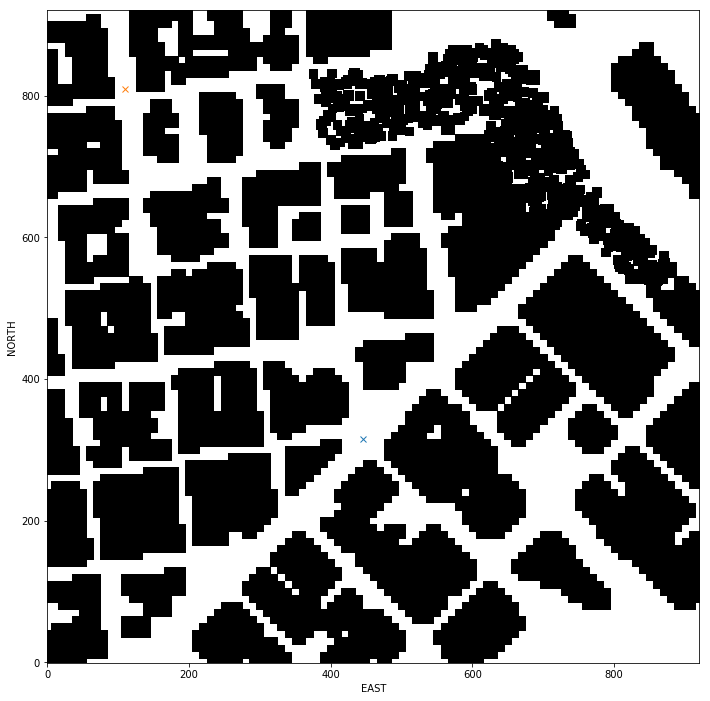

In [17]:
grid, north_offset, east_offset = create_grid(data, drone_altitude, safe_distance)
plt.rcParams['figure.figsize'] = 12, 12
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(grid_start_east, grid_start_north, 'x')
plt.plot(goal_east, goal_north, 'x')
plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [18]:
#Let's A* Modified
grid_start = (grid_start_north, grid_start_east)
grid_goal = (goal_north, goal_east)
path, cost = a_star(grid, heuristic, grid_start, grid_goal)

Found a path.


In [19]:
print(cost)

735.8082245892153


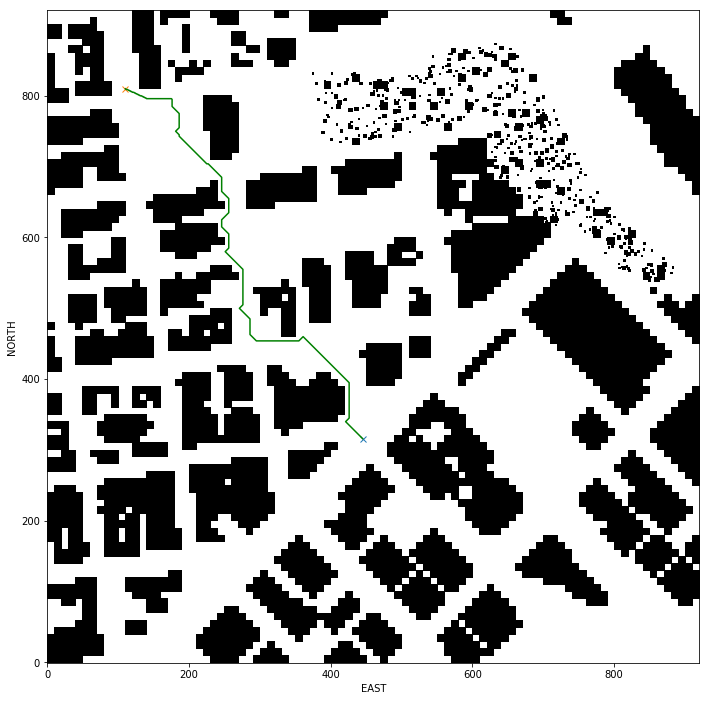

In [20]:
grid, north_offset, east_offset = create_grid(data, drone_altitude, 0)
plt.rcParams['figure.figsize'] = 12, 12
plt.imshow(grid, cmap='Greys', origin='lower')
plt.plot(grid_start_east, grid_start_north, 'x')
plt.plot(goal_east, goal_north, 'x')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [21]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()

In [22]:
conn = MavlinkConnection('tcp:127.0.0.1:5760', timeout=60)
goal = np.array([-122.401219, 37.796952, 0.0], dtype='Float64')
  
drone = MotionPlanning(conn, goal)

Logs/TLog.txt


/home/santhosh/anaconda3/envs/fcnd/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


In [23]:
time.sleep(1)

In [24]:
drone.start()

Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
global home [-122.39745   37.79248    0.     ], global position [-122.3974499   37.7924793    0.249    ], local position [-6.95254654e-02  3.52858333e-05 -2.49901235e-01]
North offset = -316, east offset = -445
Local Start and Goal:  (316, 446) (811, 110)


Traceback (most recent call last):
  File "/home/santhosh/anaconda3/envs/fcnd/lib/python3.6/site-packages/udacidrone/drone.py", line 415, in set_home_position
    self.connection.set_home_position(latitude, longitude, altitude)
  File "/home/santhosh/anaconda3/envs/fcnd/lib/python3.6/site-packages/udacidrone/connection/mavlink_connection.py", line 378, in set_home_position
    self.send_long_command(mavutil.mavlink.MAV_CMD_DO_SET_HOME, 0, 0, 0, 0, lat, lon, alt)
  File "/home/santhosh/anaconda3/envs/fcnd/lib/python3.6/site-packages/udacidrone/connection/mavlink_connection.py", line 279, in send_long_command
    self.send_message(msg)
  File "/home/santhosh/anaconda3/envs/fcnd/lib/python3.6/site-packages/udacidrone/connection/mavlink_connection.py", line 260, in send_message
    self._master.mav.send(msg)
  File "/home/santhosh/anaconda3/envs/fcnd/lib/python3.6/site-packages/pymavlink/dialects/v20/ardupilotmega.py", line 10661, in send
    buf = mavmsg.pack(self, force_mavlink1=force_ma

Found a path.
Sending waypoints to simulator ...
takeoff transition
waypoint transition
target position [0, 1, 5, 0]
waypoint transition
target position [24, -23, 5, 0]
waypoint transition
target position [25, -23, 5, 0]
waypoint transition
target position [29, -19, 5, 0]
waypoint transition
target position [79, -19, 5, 0]
waypoint transition
target position [144, -84, 5, 0]
waypoint transition
target position [138, -90, 5, 0]
waypoint transition
target position [138, -150, 5, 0]
waypoint transition
target position [147, -159, 5, 0]
waypoint transition
target position [169, -159, 5, 0]
waypoint transition
target position [184, -174, 5, 0]
waypoint transition
target position [189, -169, 5, 0]
waypoint transition
target position [239, -169, 5, 0]
waypoint transition
target position [264, -194, 5, 0]
waypoint transition
target position [269, -189, 5, 0]
waypoint transition
target position [289, -189, 5, 0]
waypoint transition
target position [299, -199, 5, 0]
waypoint transition
target po